In [1]:
import pandas as pd
import json
from gnews import GNews
import os
import openai
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
from langchain_openai  import ChatOpenAI
import pandas as pd
from transformers import AutoModelForSequenceClassification, pipeline

# Goal: Identify aspects from title and content


This chrome extension proposal will be use Google News as a search new engine. Google News cover across 141+ countries with 41+ languages. On the bottom left side of the Google News page you may find a Language & region section where you can find all of the supported combinations. The goal is to develop a Chrome web extension capable of enhancing the user experience on news search engine results pages. We will see how the chrome extension works in for the new in red box.

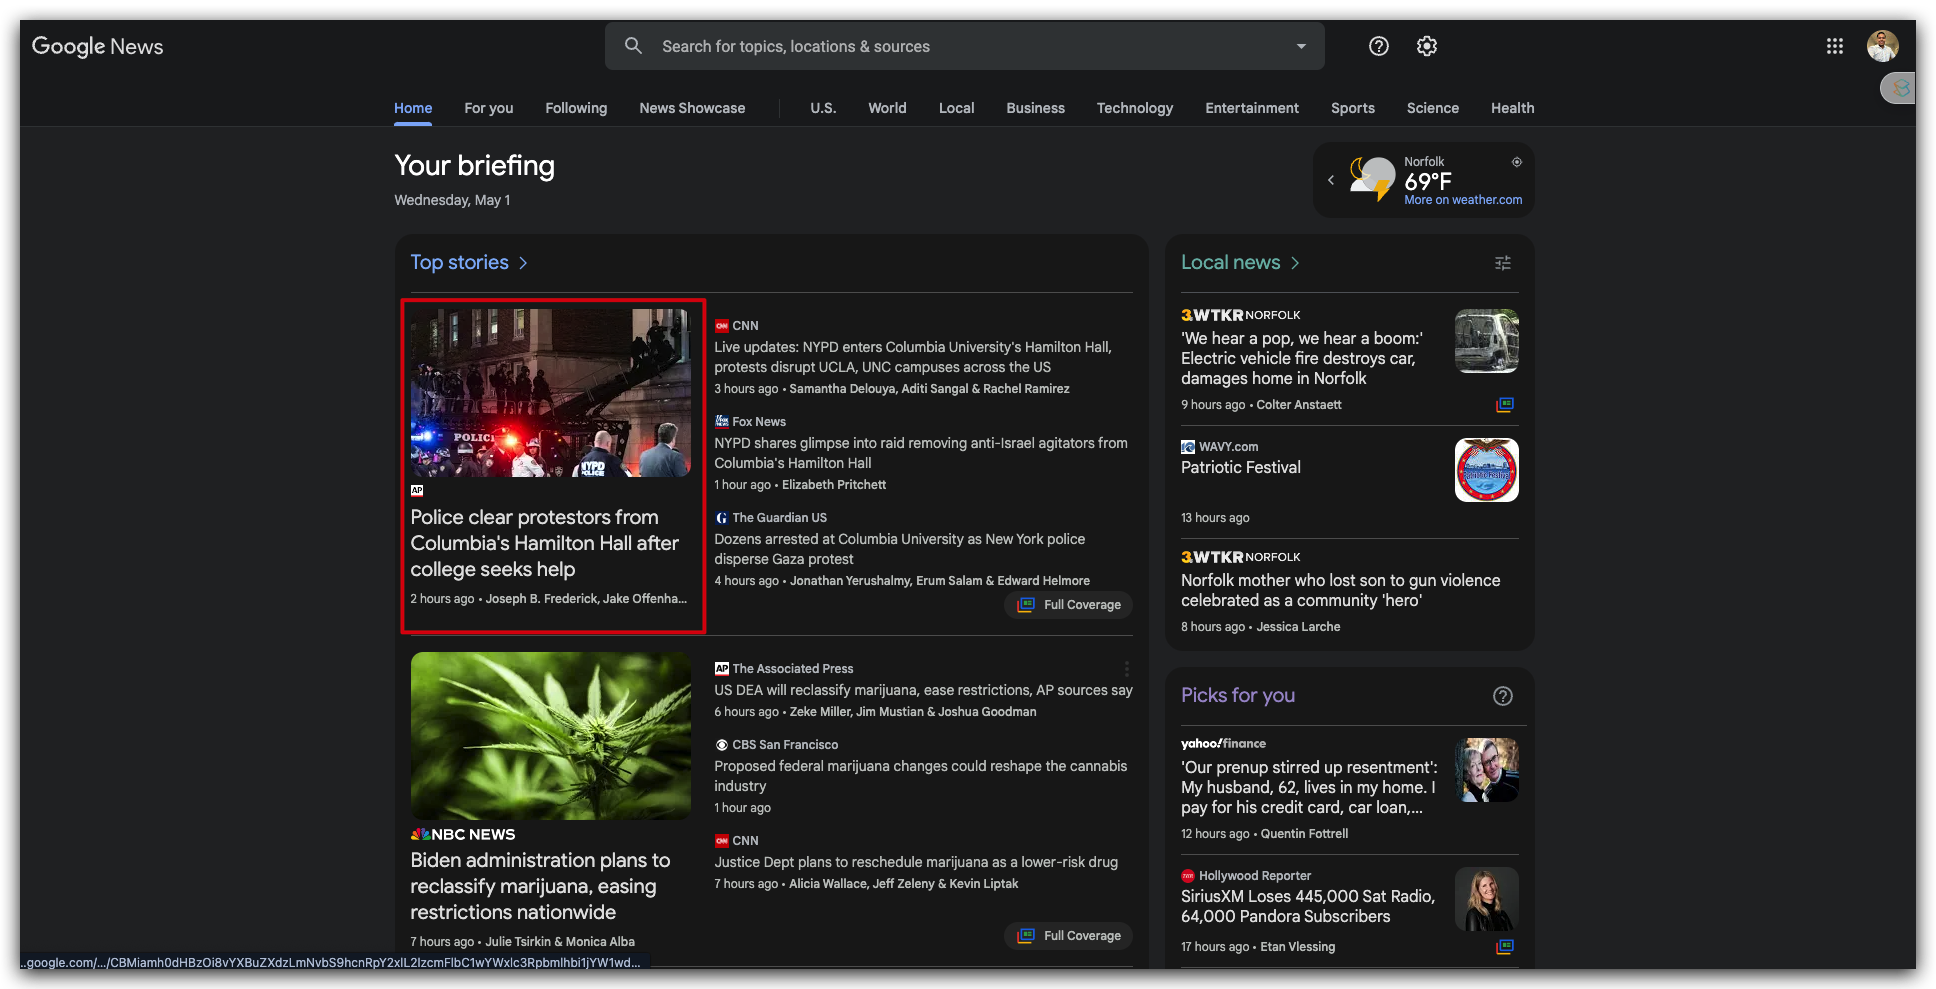


# 1. Scrapping from Google News


In [17]:
google_news = GNews()
search = "Police clear protestors from Columbia's Hamilton Hall after college seeks help"
news = google_news.get_news(search)
print(f"Number of news articles founded: {len(news)}")

Number of news articles founded: 10


In [15]:
news

[{'title': "Police clear protestors from Columbia's Hamilton Hall after college seeks help - The Associated Press",
  'description': "Police clear protestors from Columbia's Hamilton Hall after college seeks help  The Associated Press",
  'published date': 'Wed, 01 May 2024 04:12:00 GMT',
  'url': 'https://news.google.com/rss/articles/CBMiamh0dHBzOi8vYXBuZXdzLmNvbS9hcnRpY2xlL2lzcmFlbC1wYWxlc3Rpbmlhbi1jYW1wdXMtc3R1ZGVudC1wcm90ZXN0cy13YXItOGIwZDNhMGNlZGIxN2Y1ZTg5MmM2Y2E0M2JiZGY2MjjSAQA?oc=5&hl=en-US&gl=US&ceid=US:en',
  'publisher': {'href': 'https://apnews.com',
   'title': 'The Associated Press'}},
 {'title': "Police clear pro-Palestinian protesters from Columbia University's Hamilton Hall - WKMG News 6 & ClickOrlando",
  'description': "Police clear pro-Palestinian protesters from Columbia University's Hamilton Hall  WKMG News 6 & ClickOrlando",
  'published date': 'Wed, 01 May 2024 05:48:21 GMT',
  'url': 'https://news.google.com/rss/articles/CBMimwFodHRwczovL3d3dy5jbGlja29ybGFuZG8uY

In [34]:
# Select the articles that most match the search
selected_news = pd.DataFrame(news)
selected_news = selected_news[selected_news['title'].str.contains(search)]
title = selected_news['title'].iloc[0]
url = selected_news['url'].iloc[0]
print(f"Title: {title}", f"URL: {url}", sep="\n")

Title: Police clear protestors from Columbia's Hamilton Hall after college seeks help - The Associated Press
URL: https://news.google.com/rss/articles/CBMiamh0dHBzOi8vYXBuZXdzLmNvbS9hcnRpY2xlL2lzcmFlbC1wYWxlc3Rpbmlhbi1jYW1wdXMtc3R1ZGVudC1wcm90ZXN0cy13YXItOGIwZDNhMGNlZGIxN2Y1ZTg5MmM2Y2E0M2JiZGY2MjjSAQA?oc=5&hl=en-US&gl=US&ceid=US:en


In [35]:
content = []
article = google_news.get_full_article(url)
if article is not None:
    content.append({'title': article.title, 'author': article.authors, 'text': article.text, 'images': article.images, 'url': url, 'download': 1})
else:
    content.append({'title': None, 'author': None, 'text': None, 'images': None, 'url': url, 'download': 0})

content

[{'title': 'Police clear pro-Palestinian protesters from Columbia University’s Hamilton Hall',
  'author': ['Offenhartz Is A General Assignment Reporter In The New York City Bureau Of The Associated Press.',
   'Frederick Is An Associated Press Video Journalist',
   'Producer Based In New York City. His Coverage Has Included Hurricanes',
   'The Sandy Hook School Shooting',
   'The Colorado Theater Shooting.',
   'Dazio Covers Crime',
   'Criminal Justice In California For The Associated Press',
   'With A Focus On Los Angeles.'],
  'text': 'NEW YORK (AP) — Police officers carrying zip ties and riot shields stormed a Columbia University building being occupied by pro-Palestinian protesters, streaming in through a window late Tuesday and arresting dozens of people.\n\nThe protesters had seized the administration building, known as Hamilton Hall, more than 20 hours earlier in a major escalation as demonstrations against the Israel-Hamas war spread on college campuses nationwide.\n\nA pol

# 2. BERT Contextual Classification Model


In [44]:
model_name = "bllin001/bert-contextual"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
classifier = pipeline("text-classification", model=model_name)
context = classifier(title)
context

[{'label': 'contextual', 'score': 0.8001316785812378}]

In [51]:
if context[0]['label'] == 'contextual':
    note = "NOTE: The title provided enough context to understand the article."
else:
    note = "NOTE: The title did not provide enough context to understand the article."

# 3. Identify title and key points from the new

In [46]:
os.environ['OPENAI_API_KEY'] = "your_openai_api_key"
with open("../data/few-shot-examples.json") as f:
    examples = json.load(f)

In [47]:
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)

print(few_shot_prompt.format())

Human: Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign

In [48]:
final_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant who enhances the user experience on news search engine results from pages. Specifically, you should identify the full headline and the key points of news articles. Each key point has a title and the main idea. Limited your answer to providing the title and the main key points without additional information, descriptions, or explanations."),
        few_shot_prompt,
        ("human", "{input}"),
    ]
)

In [49]:
title = content[0]['title']
text = content[0]['text']
question = "What are the title and key points from the following news article?"
input = f"{question}\n\n{title}\n\n{text}"

chain = final_prompt | ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0, )

response = chain.invoke({"input": input})
print(response.content)

05/01/2024 03:58:09 AM - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Title: Police clear pro-Palestinian protesters from Columbia University’s Hamilton Hall

Key points:
1. Police officers stormed Columbia University's Hamilton Hall to clear pro-Palestinian protesters who had occupied the building for over 20 hours.
2. The protesters had seized the administration building as part of demonstrations against the Israel-Hamas war spreading on college campuses nationwide.
3. The police action came after the university requested help, citing vandalism and blockades by the protesters.
4. The White House condemned the standoffs at Columbia University and other campuses, with President Joe Biden stating that occupying academic buildings is not an example of peaceful protest.
5. Former President Donald Trump praised the police for clearing the building and criticized the delay in taking action.
6. The nationwide campus protests began in response to Israel's offensive in Gaza, with Israel's supporters branding the protests as antisemitic while organizers claim it 

# Expected chrome extension rsult

In [52]:
display_result = note + "\n\n" + response.content
print(display_result)

NOTE: The title provided enough context to understand the article.

Title: Police clear pro-Palestinian protesters from Columbia University’s Hamilton Hall

Key points:
1. Police officers stormed Columbia University's Hamilton Hall to clear pro-Palestinian protesters who had occupied the building for over 20 hours.
2. The protesters had seized the administration building as part of demonstrations against the Israel-Hamas war spreading on college campuses nationwide.
3. The police action came after the university requested help, citing vandalism and blockades by the protesters.
4. The White House condemned the standoffs at Columbia University and other campuses, with President Joe Biden stating that occupying academic buildings is not an example of peaceful protest.
5. Former President Donald Trump praised the police for clearing the building and criticized the delay in taking action.
6. The nationwide campus protests began in response to Israel's offensive in Gaza, with Israel's suppor